In [1]:
#importando o módulo de cálculo de falhas das séries
import calc_esta

#importando outras bibliotecas
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import numpy as np


In [2]:
#definindo estilo de gráficos
plt.style.use('ggplot')

In [3]:
#calculando porcentagem de falhas para diversas estações
path = r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\Dados_estações'
df_info_stations = calc_esta.read_full_stations(path) 

In [4]:
#verificando para aquelas cuja disponibilidade está compreendida no período de interesse (01-06-2000 até 30-06-2020)
df_info_stations[df_info_stations['%_falha_range'] != 'Out_of_range'] 

,Orgão,Nome_esta,Data_start,Data_end,%_falha_full,%_falha_range,geometry
Code,,,,,,,
937013,ANA,DELMIRO GOUVÉIA,1936-04-01,2023-06-30,4.926727,0.013633,POINT (-9.39280 -37.99420)
1036005,ANA,PENEDO (1),1935-01-01,2023-06-30,1.011664,0.927062,POINT (-10.28500 -36.55640)
937023,ANA,PIRANHAS (1),1935-01-01,2023-06-30,7.087832,0.054533,POINT (-9.62610 -37.75610)
937018,ANA,PÃO DE AÇÚCAR (1),1935-01-01,2023-06-30,7.539523,0.422631,POINT (-9.74860 -37.44970)
937032,ANA,SANTANA DO IPANEMA (1),1978-11-12,2023-06-30,0.552079,0.899796,POINT (-9.37280 -37.24530)
936076,ANA,TRAIPU (1),1973-01-01,2023-06-30,5.020875,0.027267,POINT (-9.97280 -37.00330)


In [5]:
#Vamos analisar a estação de Traipu
df_traipu = calc_esta.read_station(r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\Dados_estações\TRAIPU (1).xlsx')
df_traipu.head()

Data  Precipitação (mm)
ID         geometry                                              
ANA_936076 POINT (-9.9728 -37.0033) 1973-01-01                0.0
           POINT (-9.9728 -37.0033) 1973-01-02                0.0
           POINT (-9.9728 -37.0033) 1973-01-03                1.7
           POINT (-9.9728 -37.0033) 1973-01-04                0.5
           POINT (-9.9728 -37.0033) 1973-01-05                0.2

### 2.0 - Visualizando algumas estatísticas

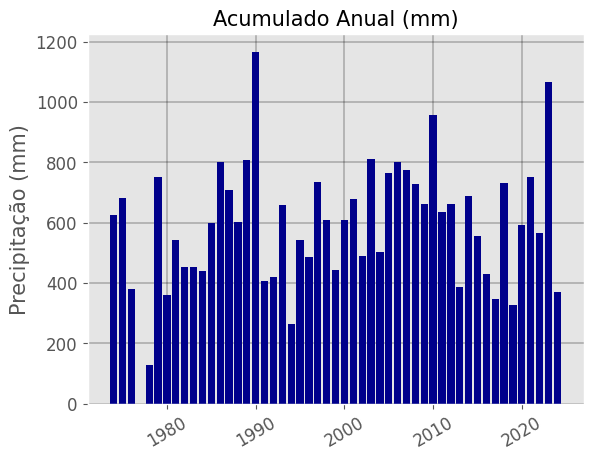

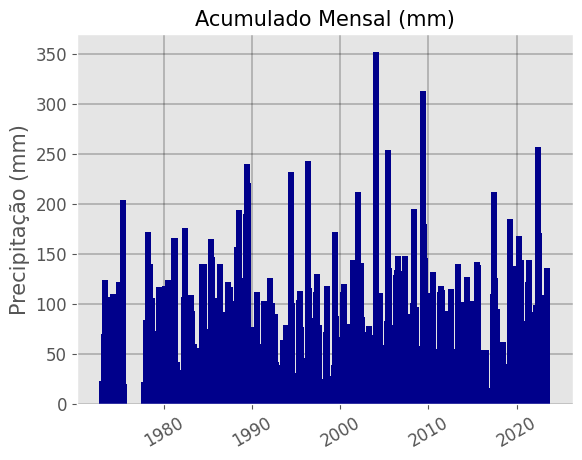

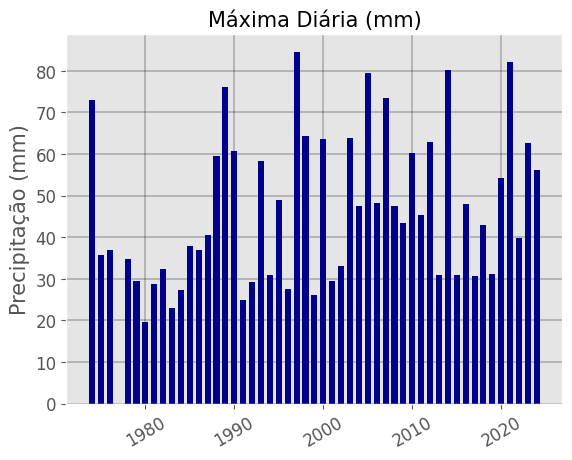

In [6]:
#calculando algumas métricas comumente avaliadas
traipu_acum_anual = df_traipu.groupby(pd.Grouper(key='Data', freq='Y'))['Precipitação (mm)'].sum()
traipu_acum_mensal = df_traipu.groupby(pd.Grouper(key='Data', freq='M'))['Precipitação (mm)'].sum()
traipu_max_dia = df_traipu.groupby(pd.Grouper(key='Data', freq='Y'))['Precipitação (mm)'].max()

#amazenando os dados para auxiliar na plotagem dos gráficos
lista_parametros_interesse = [traipu_acum_anual, traipu_acum_mensal, traipu_max_dia]
lista_titles = ['Acumulado Anual (mm)', 'Acumulado Mensal (mm)', 'Máxima Diária (mm)']

for i in range(len(lista_parametros_interesse)): 
    if i == 0:
        width_bar = 300
    else:
        width_bar = 250 

    plt.figure()

    plt.bar(lista_parametros_interesse[i].index, lista_parametros_interesse[i], color='darkblue', width=width_bar)
    name_title = lista_titles[i]
    plt.title(name_title, size=15, color='black')
    plt.ylabel('Precipitação (mm)', size=15)
    plt.xticks(size=12, rotation=30)
    plt.yticks(size=12) 

    plt.grid(linestyle = '-', linewidth = 0.3, color='black')
    plt.show() 

In [10]:
traipu_max_dia.dropna(inplace=True)

### 3.0 - Investigando distribuição para precipitação máxima diária

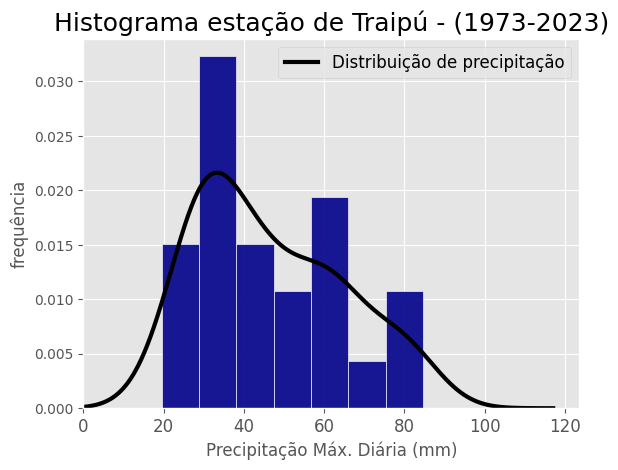

In [11]:
#visuzalizando histograma dos valores acumulados mensais 
plt.figure()
(traipu_max_dia).plot.kde(legend=False, color='black', linewidth=3)

plt.hist([traipu_max_dia], bins='auto', density=True, color='darkblue', alpha=0.9, edgecolor='white')

plt.title('Histograma estação de Traipú - (1973-2023)', size=18)
plt.xlabel('Precipitação Máx. Diária (mm)', size=12)
plt.xticks(fontsize=12) 
plt.xlim(0)
plt.ylabel('frequência', size=12)
plt.legend(['Distribuição de precipitação'], fontsize=12)

plt.show() 

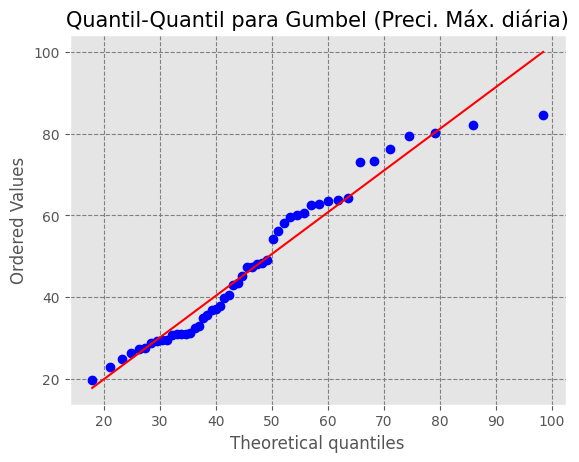

In [12]:
#vamos investigar uma distribuição de probabilidade que melhor modele os dados

#Visualizando aderência (Gumbel)
parametros_gumbel = scipy.stats.gumbel_r.fit(traipu_max_dia)
scipy.stats.probplot(traipu_max_dia, dist=scipy.stats.gumbel_r, sparams=parametros_gumbel, plot=plt)
plt.title('Quantil-Quantil para Gumbel (Preci. Máx. diária)', size=15)
plt.grid(linestyle = '--', linewidth = .8, color='gray')

plt.show() 


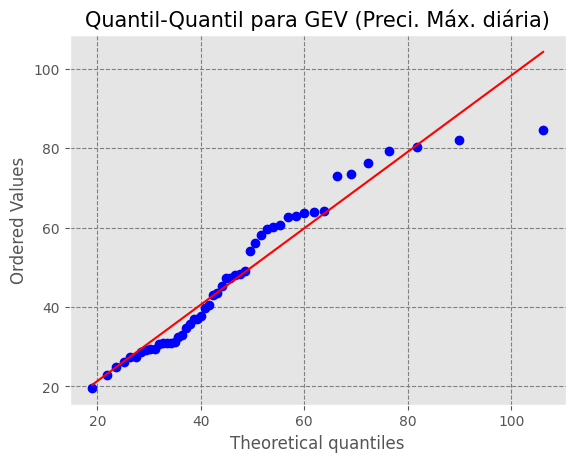

In [13]:
#Visualizando aderência (GEV)
parametros_gev = scipy.stats.genextreme.fit(traipu_max_dia)
scipy.stats.probplot(traipu_max_dia, dist=scipy.stats.genextreme, sparams=parametros_gev, plot=plt)
plt.title('Quantil-Quantil para GEV (Preci. Máx. diária)', size=15)
plt.grid(linestyle = '--', linewidth = .8, color='gray')

plt.show() 

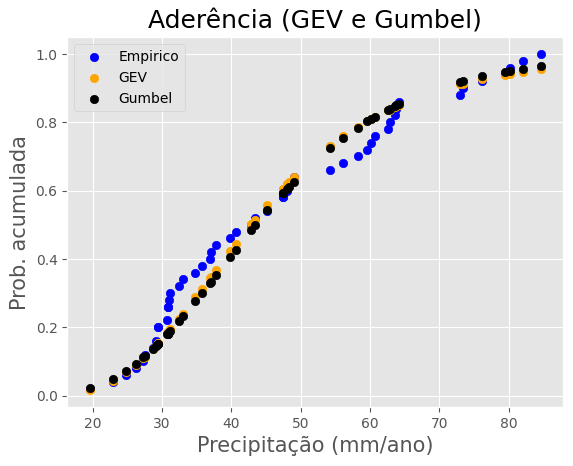

In [14]:
# Função para obter CDF dos dados
def cdf(sample, x, sort = False):
  #sample: dataseries da amostra
    #Caso os dados da amostra não estejam em ordem crescente, iremos realizar
    if sort:
      sample = sample.sort_values()
    #Verificar quantos valores são inferiores a referência (x) desejada
    cdf = sum(sample <= x)
    # Calculando a probabilidade
    cdf = cdf / len(sample)
    return cdf

#obtendo parâmetros para distribuição GEV
param_gev = scipy.stats.genextreme.fit(traipu_max_dia)
alpha = param_gev[0] #forma da distribuição
loc= param_gev[1]
scale = param_gev[2]

#obtendo parâmetros para distribuição gumbel
param_gumbel = scipy.stats.gumbel_r.fit(traipu_max_dia)
mean_gumbel = param_gumbel[0]
std_gumbel = param_gumbel[1]

valores_empiricos = []
valores_teoricos_gev = []
valores_teoricos_gumbel = []

#loop para calcular os valores CDF empíricos e acumulados
for x in traipu_max_dia:
  cdf_gumbel = scipy.stats.gumbel_r.cdf(x=x, loc=mean_gumbel, scale=std_gumbel)
  cdf_gev = scipy.stats.genextreme.cdf(x=x, c=alpha, loc=loc, scale=scale)
  cdf_sample = cdf(sample = traipu_max_dia, x  = x)

  #salvando nas listas
  valores_empiricos.append(cdf_sample)
  valores_teoricos_gev.append(cdf_gev)
  valores_teoricos_gumbel.append(cdf_gumbel)

#vamos construir um gráfico comparando as distribuições
plt.scatter(x=traipu_max_dia.to_list(), y=valores_empiricos, color='blue')
plt.scatter(x=traipu_max_dia.to_list(), y=valores_teoricos_gev, color='orange')
plt.scatter(x=traipu_max_dia.to_list(), y=valores_teoricos_gumbel, color='black')

plt.title('Aderência (GEV e Gumbel)', size=18)
plt.xlabel('Precipitação (mm/ano)', size=15)
plt.ylabel('Prob. acumulada', size=15)
plt.legend(['Empirico', 'GEV', 'Gumbel'])
plt.show()

#### 3.1 - Teste de aderência (Kolmogorov-Smirnov)

In [15]:
# Komolgorov-Smirnov para distribuição Gumbell
def ks_gumbel(sample):

  # Organizando os dados da amostra em ordem crescente
  sample = sample.sort_values()

  # Extraindo parâmetros
  param = scipy.stats.gumbel_r.fit(sample)
  media = param[0]
  desv_std = param[1]

  # Criando uma lista para armazenarmos os valores de critério D_ks
  D_ks = []

  #Loop para obter as probabilidades empíricas e teóricas
  for x in sample:
    cdf_gev = scipy.stats.gumbel_r.cdf(x = x, loc = media , scale = desv_std)
    cdf_sample = cdf(sample = sample, x  = x)
    #guardando em uma lista as "distâncias" entre os valores empíricos e teóricos
    D_ks.append(abs(cdf_gev - cdf_sample))

  #obtendo a máxima distância
  ks_stat = max(D_ks)

  # Calculates the P-Value based on the two-sided test
  # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
  p_value = scipy.stats.kstwo.sf(ks_stat, len(sample))
  return {"ks_stat": ks_stat, "p_value" : p_value}

# Komolgorov-Smirnov para distribuição Gumbell
def ks_gev(sample):

  # Organizando os dados da amostra em ordem crescente
  sample = sample.sort_values()

  # Extraindo parâmetros
  param = scipy.stats.genextreme.fit(sample)
  c = param[0]
  media = param[1]
  desv_std = param[2]

  # Criando uma lista para armazenarmos os valores de critério D_ks
  D_ks = []

  #Loop para obter as probabilidades empíricas e teóricas
  for x in sample:
    cdf_gev = scipy.stats.genextreme.cdf(x = x, c=c, loc = media , scale = desv_std)
    cdf_sample = cdf(sample = sample, x  = x)
    #guardando em uma lista as "distâncias" entre os valores empíricos e teóricos
    D_ks.append(abs(cdf_gev - cdf_sample))

  #obtendo a máxima distância
  ks_stat = max(D_ks)

  # Calculates the P-Value based on the two-sided test
  # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
  p_value = scipy.stats.kstwo.sf(ks_stat, len(sample))
  return {"ks_stat": ks_stat, "p_value" : p_value}

In [16]:
print('Gumbel:', ks_gumbel(traipu_max_dia))
print('GEV:', ks_gev(traipu_max_dia))


Gumbel: {'ks_stat': 0.10958690383942335, 'p_value': 0.5486790683120023}
GEV: {'ks_stat': 0.10516925002918118, 'p_value': 0.6005556336049607}


### 4.0 - Tempo de retorno

In [17]:
traipu_ord = (traipu_max_dia.sort_values(ascending=False)).reset_index()


len(traipu_ord[traipu_ord['Precipitação (mm)'] >= traipu_ord.loc[0]['Precipitação (mm)']])/len(traipu_ord)

0.02

C:\Users\Ari\AppData\Local\Temp\ipykernel_10536\2295675443.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.scatter( (1/(1-values_prob)), prec_gumbel, color='black')


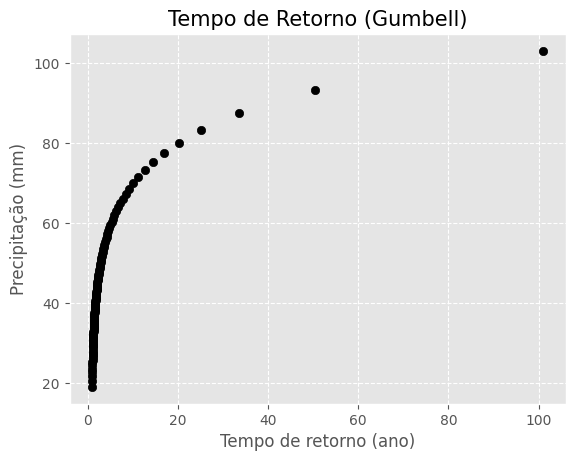

In [19]:
parametros_gumbel = scipy.stats.gumbel_r.fit(traipu_max_dia)
values_prob = np.linspace(0.02, 1, 10**2)
prec_gumbel = scipy.stats.gumbel_r.ppf(values_prob, loc=parametros_gumbel[0], scale=parametros_gumbel[1])

#Distribuiçao de Gumbel (expressa em TR)
plt.scatter( (1/(1-values_prob)), prec_gumbel, color='black')
plt.title('Tempo de Retorno (Gumbell)', fontsize=15)
plt.ylabel('Precipitação (mm)', fontsize=12)
plt.xlabel('Tempo de retorno (ano)', fontsize=12)
plt.grid(linestyle='--')
plt.show() 